# Spatial Mapping of Spectral Neuron Clusters

Notebook 02 found two spectral neuron clusters (70% slow-dominated, 30% high-freq enriched) and showed that only the 30% minority classifies behavior above chance. This notebook maps those clusters onto their **physical brain locations** using spatial footprint data from the source EDGE calcium imaging pipeline.

**Questions:**
1. Are the behaviorally-relevant (Cluster 1) neurons spatially clustered or scattered?
2. Do their calcium traces show visibly different activity patterns during social epochs?
3. Do high-frequency neurons co-localize, suggesting a shared microcircuit?

---
## 1. Setup & Data Loading

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from scipy.ndimage import center_of_mass
from scipy.signal import detrend
from scipy.spatial.distance import cdist

from src.constants import IMAGING_FPS, FREQ_BANDS, BAND_COLORS
from src.data import (download_data, load_entrances, load_behavior,
                      load_imaging, align_all_sessions, load_spatial_footprints)
from src.analysis import compute_neuron_spectral_profiles, cluster_neurons
from src.visualization import shade_social

sns.set_theme(style='whitegrid', context='notebook', font_scale=1.1)
plt.rcParams['figure.dpi'] = 100
np.random.seed(42)
print('All imports successful.')

All imports successful.


In [2]:
# Download all data (including spatial footprints)
DATA_DIR = download_data()

# Load standard pipeline data
entrances = load_entrances(DATA_DIR)
n_sessions = len(entrances)
behavior = load_behavior(n_sessions, DATA_DIR)
imaging = load_imaging(n_sessions, DATA_DIR)
aligned_calcium, aligned_behavior, session_info, session_df = align_all_sessions(
    imaging, behavior, entrances
)

# Load spatial footprints (Session 0 only)
spatial = load_spatial_footprints(DATA_DIR)
A = spatial['A']    # (202, 600, 600)
Cn = spatial['Cn']  # (600, 600)
print(f'\nSpatial footprints: {A.shape[0]} neurons, {A.shape[1]}x{A.shape[2]} FOV')
print(f'Correlation image: {Cn.shape}')

  [skip] calcium.00.h5 (238.6 MB)
  [skip] social_bouts.00.h5 (0.5 MB)
  [skip] SI3_2022_Entrance_Frames.xlsx (0.0 MB)
  [skip] spatial_footprints.00.h5 (33.8 MB)
  Session  0:   7788 frames, 202 neurons, 260s, 38.9% social, GH (7d)
  Session  1:   8776 frames,  12 neurons, 293s, 41.5% social, GH (7d)
  Session  2:   8847 frames, 289 neurons, 295s, 16.3% social, GH (7d)
  Session  3:   8887 frames, 268 neurons, 296s, 25.3% social, 24hr
  Session  4:   8895 frames, 134 neurons, 296s, 30.4% social, 24hr
  Session  5:   8882 frames, 271 neurons, 296s, 38.0% social, 24hr
  Session  6:   8897 frames, 218 neurons, 297s, 21.6% social, 7d
  Session  7:   8872 frames, 207 neurons, 296s, 30.7% social, 7d
  Session  8:   8830 frames, 332 neurons, 294s, 32.5% social, 7d
  Session  9:   8882 frames, 396 neurons, 296s, 29.7% social, GH (24hr)
  Session 10:   8860 frames, 288 neurons, 295s, 24.1% social, GH (24hr)
  Session 11:   6544 frames,  96 neurons, 218s, 36.2% social, GH (24hr)
  Session 12:  

In [3]:
# Compute spectral profiles and cluster labels for ALL sessions
# (same as notebook 02 to ensure consistent cluster assignments)
profile_df = compute_neuron_spectral_profiles(aligned_calcium, session_info)
labels_all, centroids, best_k, sil_scores = cluster_neurons(profile_df)
profile_df['cluster'] = labels_all

print(f'Total neurons: {len(profile_df)}')
print(f'Best k = {best_k}, silhouette = {sil_scores[best_k]:.4f}')
print(f'Cluster 0: {(labels_all == 0).sum()} neurons')
print(f'Cluster 1: {(labels_all == 1).sum()} neurons')

# Extract Session 0 labels (session_idx == 0, 202 neurons)
sess0_mask = profile_df['session_idx'] == 0
sess0_df = profile_df[sess0_mask].copy()
n_sess0 = len(sess0_df)

# Build neuron_id -> cluster lookup for Session 0
cluster_map = np.full(A.shape[0], -1, dtype=int)
for _, row in sess0_df.iterrows():
    cluster_map[int(row['neuron_id'])] = int(row['cluster'])

c0_idx = np.where(cluster_map == 0)[0]
c1_idx = np.where(cluster_map == 1)[0]

print(f'\nSession 0: {n_sess0} neurons with valid PSD')
print(f'  Cluster 0 (slow-dominated): {len(c0_idx)}')
print(f'  Cluster 1 (high-freq enriched): {len(c1_idx)}')
print(f'  Cluster 1 fraction: {len(c1_idx)/n_sess0:.1%}')

Total neurons: 3938
Best k = 2, silhouette = 0.3991
Cluster 0: 2762 neurons
Cluster 1: 1176 neurons

Session 0: 202 neurons with valid PSD
  Cluster 0 (slow-dominated): 157
  Cluster 1 (high-freq enriched): 45
  Cluster 1 fraction: 22.3%


In [4]:
# Compute neuron centroids (center of mass of each spatial footprint)
centroids_yx = np.array([center_of_mass(A[i]) for i in range(A.shape[0])])
# Filter to neurons with valid cluster assignments
valid_mask = cluster_map >= 0
print(f'Centroid range: y=[{centroids_yx[valid_mask, 0].min():.0f}, {centroids_yx[valid_mask, 0].max():.0f}], '
      f'x=[{centroids_yx[valid_mask, 1].min():.0f}, {centroids_yx[valid_mask, 1].max():.0f}]')

Centroid range: y=[27, 390], x=[79, 515]


---
## 2. Spatial Map of Cluster 0 vs Cluster 1

We overlay neuron spatial footprints on the correlation image (Cn), color-coded by spectral cluster. This reveals whether the behaviorally-relevant high-frequency neurons (Cluster 1, red) are spatially organized or randomly intermixed with the slow-dominated majority (Cluster 0, blue).

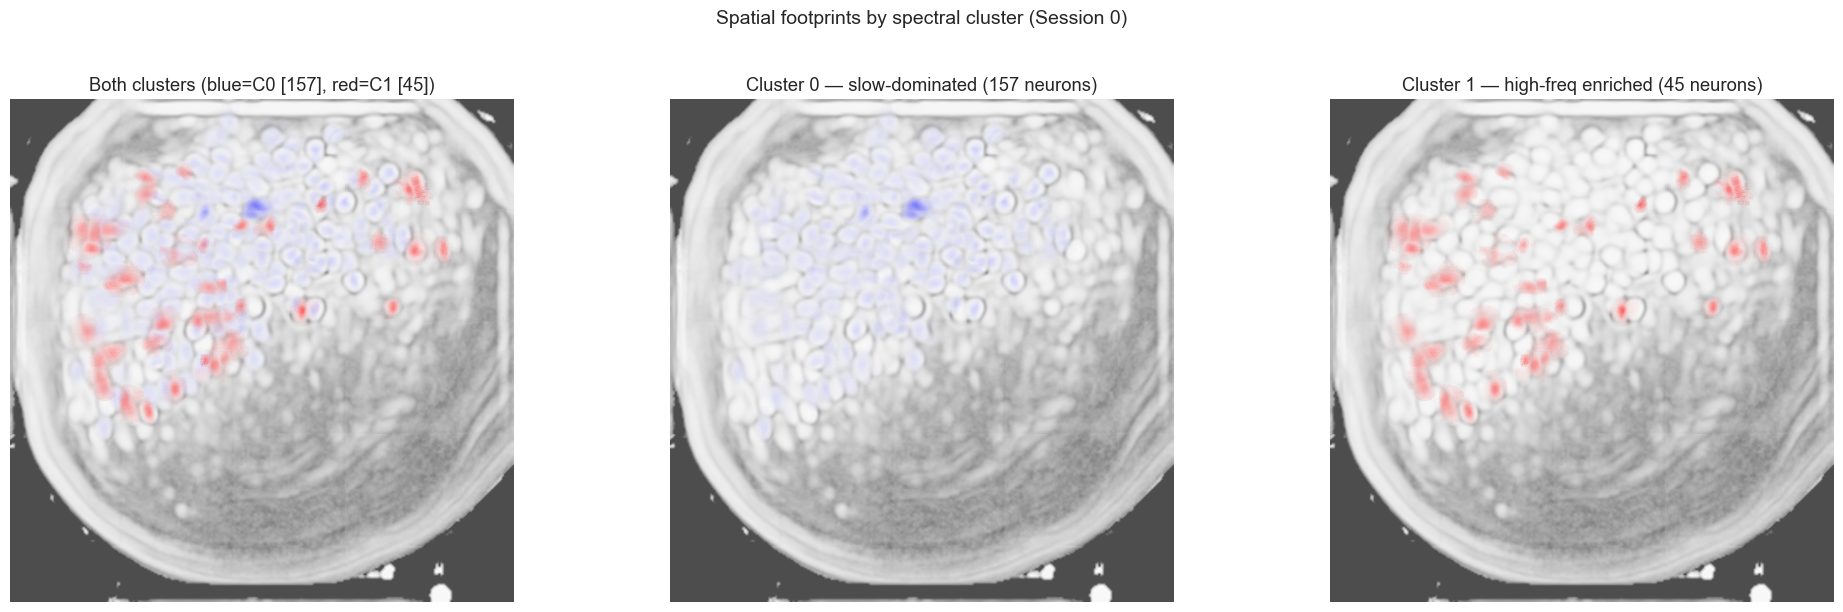

In [5]:
# Build composite footprint images per cluster
footprint_c0 = np.max(A[c0_idx], axis=0) if len(c0_idx) > 0 else np.zeros_like(Cn)
footprint_c1 = np.max(A[c1_idx], axis=0) if len(c1_idx) > 0 else np.zeros_like(Cn)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Left: Both clusters overlaid on Cn
axes[0].imshow(Cn, cmap='gray', alpha=0.7)
# Overlay Cluster 0 in blue
c0_overlay = np.zeros((*Cn.shape, 4))
c0_norm = footprint_c0 / (footprint_c0.max() + 1e-12)
c0_overlay[..., 2] = 1.0   # blue channel
c0_overlay[..., 3] = c0_norm * 0.5
axes[0].imshow(c0_overlay)
# Overlay Cluster 1 in red
c1_overlay = np.zeros((*Cn.shape, 4))
c1_norm = footprint_c1 / (footprint_c1.max() + 1e-12)
c1_overlay[..., 0] = 1.0   # red channel
c1_overlay[..., 3] = c1_norm * 0.6
axes[0].imshow(c1_overlay)
axes[0].set_title(f'Both clusters (blue=C0 [{len(c0_idx)}], red=C1 [{len(c1_idx)}])')
axes[0].axis('off')

# Middle: Cluster 0 only
axes[1].imshow(Cn, cmap='gray', alpha=0.7)
axes[1].imshow(c0_overlay)
axes[1].set_title(f'Cluster 0 — slow-dominated ({len(c0_idx)} neurons)')
axes[1].axis('off')

# Right: Cluster 1 only
axes[2].imshow(Cn, cmap='gray', alpha=0.7)
axes[2].imshow(c1_overlay)
axes[2].set_title(f'Cluster 1 — high-freq enriched ({len(c1_idx)} neurons)')
axes[2].axis('off')

plt.suptitle('Spatial footprints by spectral cluster (Session 0)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

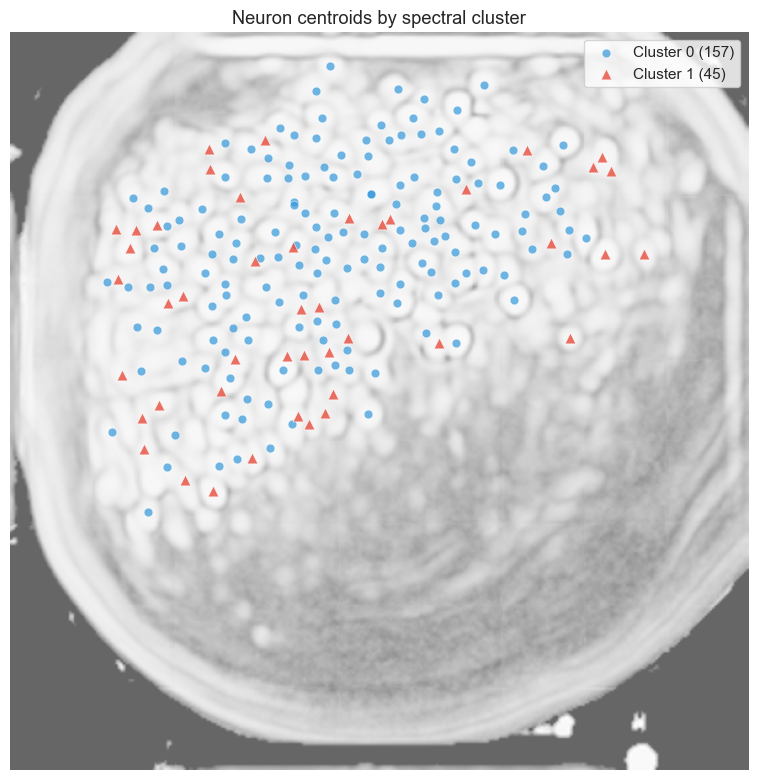

In [6]:
# Centroid scatter overlay on Cn
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(Cn, cmap='gray', alpha=0.6)

ax.scatter(centroids_yx[c0_idx, 1], centroids_yx[c0_idx, 0],
           c='#3498db', s=40, alpha=0.7, edgecolors='white', linewidths=0.5,
           label=f'Cluster 0 ({len(c0_idx)})', zorder=3)
ax.scatter(centroids_yx[c1_idx, 1], centroids_yx[c1_idx, 0],
           c='#e74c3c', s=60, alpha=0.8, edgecolors='white', linewidths=0.5,
           marker='^', label=f'Cluster 1 ({len(c1_idx)})', zorder=4)

ax.legend(loc='upper right', fontsize=11)
ax.set_title('Neuron centroids by spectral cluster')
ax.axis('off')
plt.tight_layout()
plt.show()

### Section 2 Interpretation

The spatial footprint overlay shows the physical distribution of the two spectral clusters across the field of view. Cluster 0 (blue, slow-dominated majority) and Cluster 1 (red, high-freq enriched minority) can be compared for spatial organization patterns:

- If Cluster 1 neurons form spatial clusters, this would suggest they belong to a common microcircuit or cortical layer.
- If they are scattered uniformly, the spectral difference is more likely a cell-type property than a location-dependent effect.

The centroid scatter plot provides a cleaner view of the spatial distribution without the overlap of extended footprints.

---
## 3. Calcium Activity Alongside Behavioral Epochs

We visualize how calcium traces from each cluster behave during social vs. solo epochs. Neurons are sorted by cluster, with the cluster boundary marked, and social epochs shaded on the time axis.

In [7]:
# Get Session 0 aligned data
cal_s0 = aligned_calcium[0]   # (n_frames, 202)
beh_s0 = aligned_behavior[0]  # (n_frames,)
t_s0 = np.arange(len(beh_s0)) / IMAGING_FPS

# Z-score each neuron's trace
cal_z = np.zeros_like(cal_s0, dtype=np.float64)
for ni in range(cal_s0.shape[1]):
    trace = cal_s0[:, ni].astype(np.float64)
    mu, sd = trace.mean(), trace.std()
    cal_z[:, ni] = (trace - mu) / (sd + 1e-12)

# Sort neurons: Cluster 0 first, then Cluster 1
sort_order = np.concatenate([c0_idx, c1_idx])
cal_z_sorted = cal_z[:, sort_order].T  # (n_neurons_sorted, n_frames)
boundary = len(c0_idx)

print(f'Session 0: {cal_s0.shape[0]} frames ({t_s0[-1]:.0f}s), {cal_s0.shape[1]} neurons')
print(f'Social fraction: {beh_s0.mean():.1%}')
print(f'Display order: {boundary} Cluster 0, then {len(c1_idx)} Cluster 1')

Session 0: 7788 frames (260s), 202 neurons
Social fraction: 38.9%
Display order: 157 Cluster 0, then 45 Cluster 1


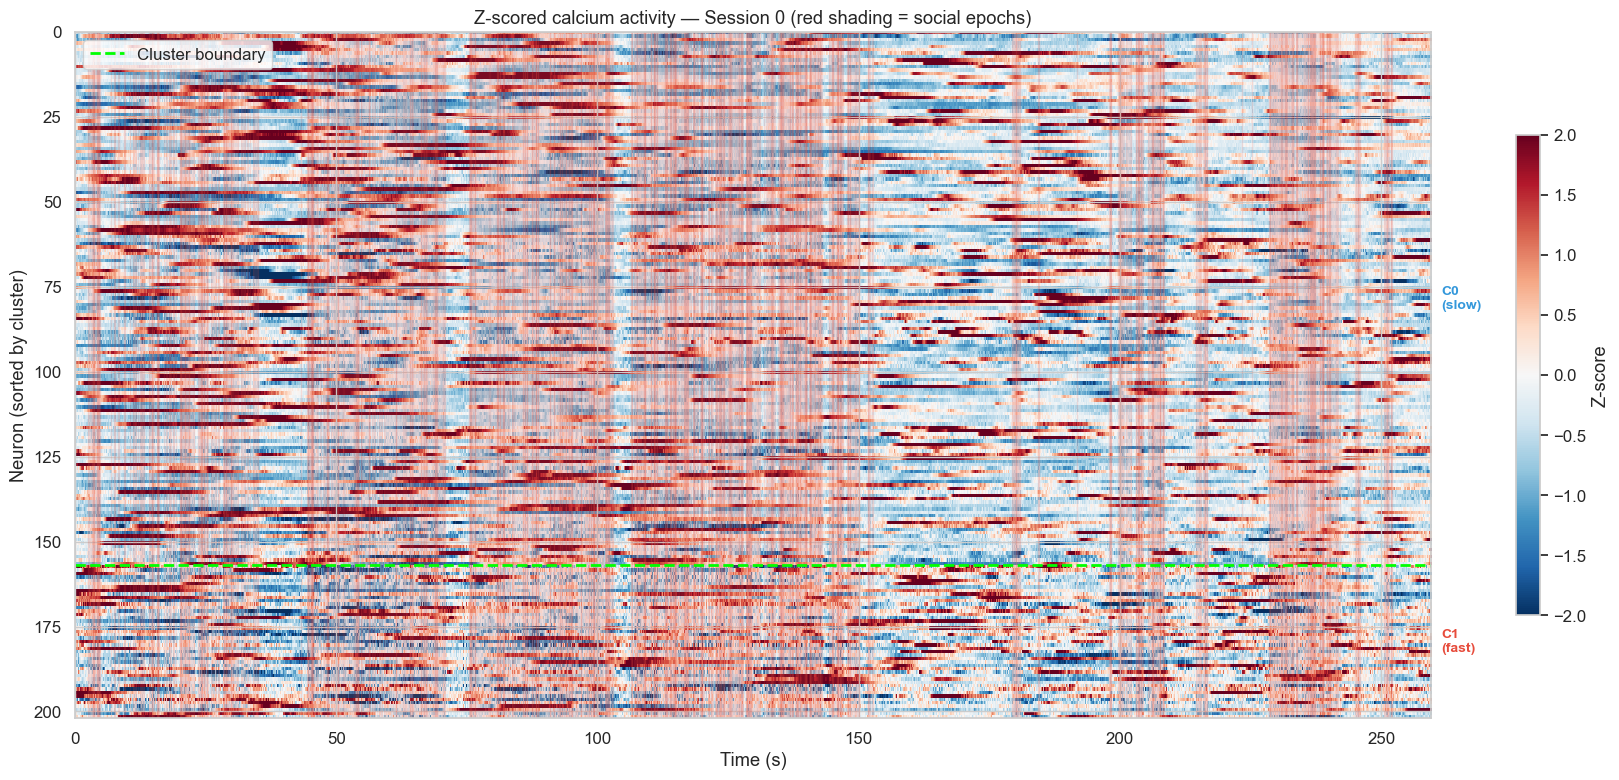

In [8]:
# Full-session raster/heatmap
fig, ax = plt.subplots(1, 1, figsize=(18, 8))

im = ax.imshow(cal_z_sorted, aspect='auto', cmap='RdBu_r',
               vmin=-2, vmax=2,
               extent=[t_s0[0], t_s0[-1], cal_z_sorted.shape[0], 0],
               interpolation='none')

# Mark cluster boundary
ax.axhline(boundary, color='lime', lw=2, ls='--', label='Cluster boundary')

# Shade social epochs on a secondary x-axis strip at bottom
shade_social(ax, beh_s0, t_s0)

ax.set_xlabel('Time (s)')
ax.set_ylabel('Neuron (sorted by cluster)')
ax.set_title('Z-scored calcium activity — Session 0 (red shading = social epochs)')

# Cluster labels
ax.text(t_s0[-1] + 2, boundary / 2, 'C0\n(slow)', va='center', fontsize=10, color='#3498db', fontweight='bold')
ax.text(t_s0[-1] + 2, boundary + len(c1_idx) / 2, 'C1\n(fast)', va='center', fontsize=10, color='#e74c3c', fontweight='bold')

plt.colorbar(im, ax=ax, label='Z-score', shrink=0.7)
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()

Longest social bout: 2.6s (frames 2297–2376)
Zoom window: 47.9s – 107.9s


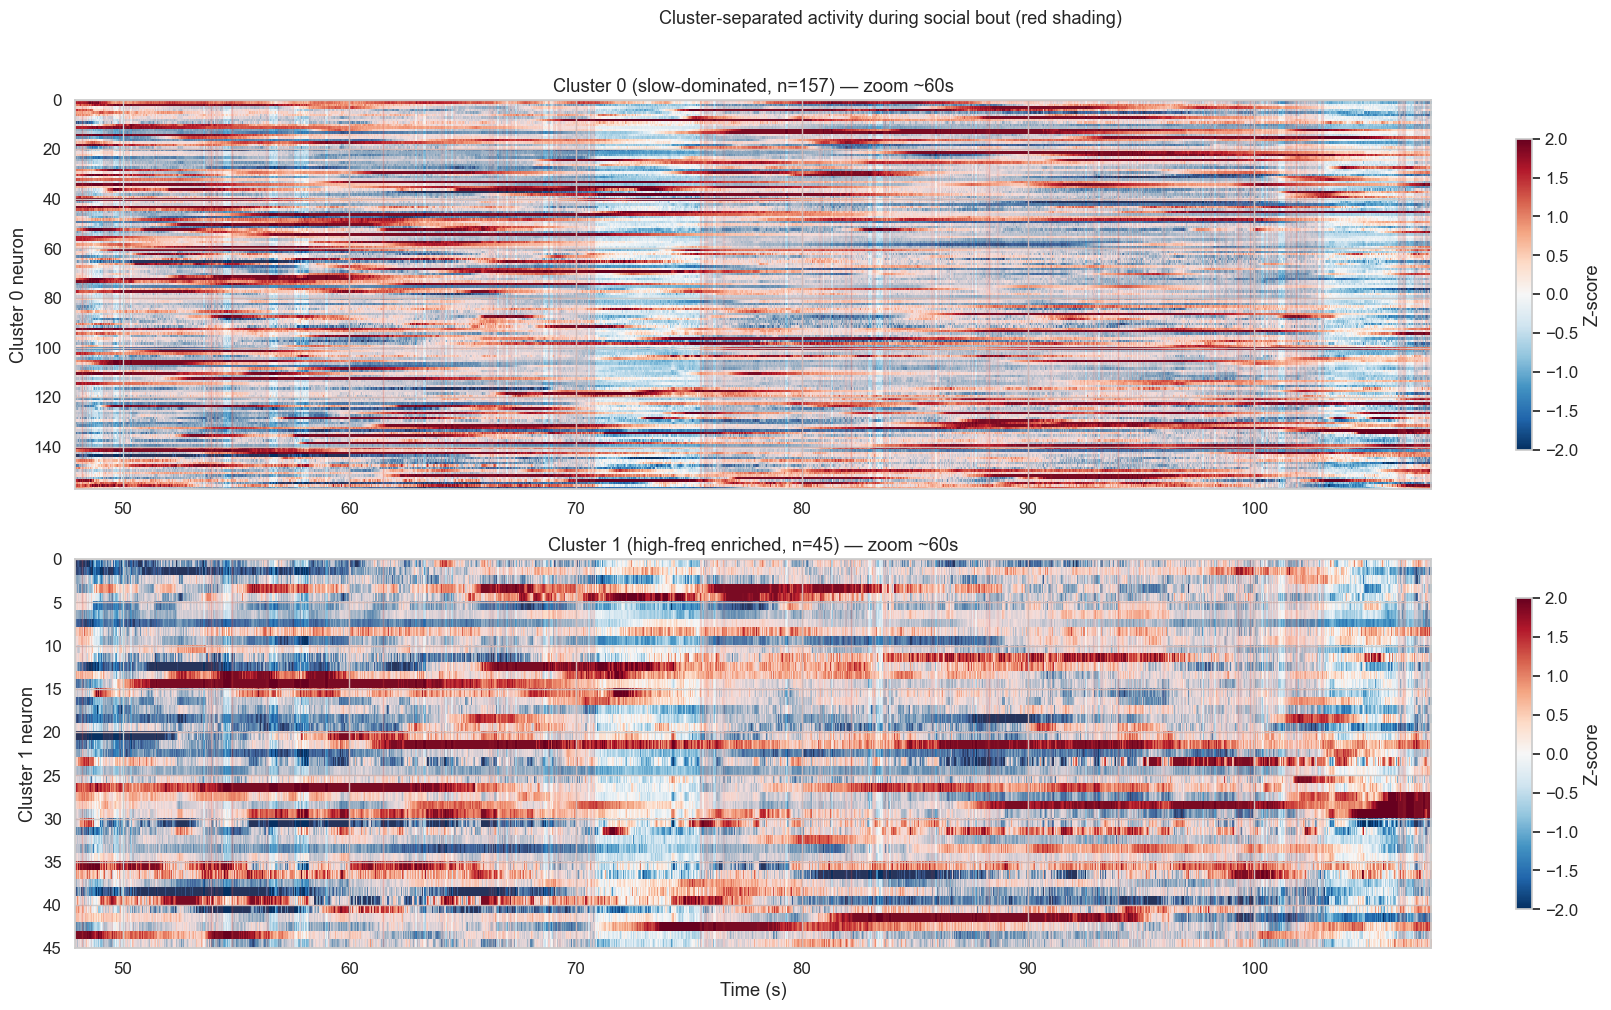

In [9]:
# Zoom into a ~60s window containing a social bout
# Find a social bout longer than 3 seconds
social_mask = beh_s0.astype(bool)
d = np.diff(social_mask.astype(int))
starts = np.where(d == 1)[0] + 1
ends = np.where(d == -1)[0] + 1
if social_mask[0]:
    starts = np.concatenate([[0], starts])
if social_mask[-1]:
    ends = np.concatenate([ends, [len(social_mask)]])

# Pick the longest social bout
bout_durations = (ends - starts) / IMAGING_FPS
longest_idx = np.argmax(bout_durations)
bout_center = (starts[longest_idx] + ends[longest_idx]) // 2
zoom_start = max(0, bout_center - int(30 * IMAGING_FPS))
zoom_end = min(len(beh_s0), bout_center + int(30 * IMAGING_FPS))

print(f'Longest social bout: {bout_durations[longest_idx]:.1f}s '
      f'(frames {starts[longest_idx]}–{ends[longest_idx]})')
print(f'Zoom window: {zoom_start/IMAGING_FPS:.1f}s – {zoom_end/IMAGING_FPS:.1f}s')

fig, axes = plt.subplots(2, 1, figsize=(18, 10), gridspec_kw={'height_ratios': [1, 1]})

t_zoom = t_s0[zoom_start:zoom_end]
cal_zoom = cal_z_sorted[:, zoom_start:zoom_end]
beh_zoom = beh_s0[zoom_start:zoom_end]

# Top: Cluster 0 neurons
im0 = axes[0].imshow(cal_zoom[:boundary], aspect='auto', cmap='RdBu_r',
                      vmin=-2, vmax=2,
                      extent=[t_zoom[0], t_zoom[-1], boundary, 0],
                      interpolation='none')
shade_social(axes[0], beh_zoom, t_zoom)
axes[0].set_ylabel('Cluster 0 neuron')
axes[0].set_title(f'Cluster 0 (slow-dominated, n={len(c0_idx)}) — zoom ~60s')
plt.colorbar(im0, ax=axes[0], label='Z-score', shrink=0.8)

# Bottom: Cluster 1 neurons
im1 = axes[1].imshow(cal_zoom[boundary:], aspect='auto', cmap='RdBu_r',
                      vmin=-2, vmax=2,
                      extent=[t_zoom[0], t_zoom[-1], len(c1_idx), 0],
                      interpolation='none')
shade_social(axes[1], beh_zoom, t_zoom)
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Cluster 1 neuron')
axes[1].set_title(f'Cluster 1 (high-freq enriched, n={len(c1_idx)}) — zoom ~60s')
plt.colorbar(im1, ax=axes[1], label='Z-score', shrink=0.8)

plt.suptitle('Cluster-separated activity during social bout (red shading)', fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

### Section 3 Interpretation

The full-session raster shows z-scored calcium activity for all Session 0 neurons, sorted by spectral cluster. Social epochs (red shading) allow visual comparison of how each cluster's activity changes between behavioral states.

The zoomed view separates the two clusters during the longest social bout, making it easier to spot:
- **Synchronous activation patterns** within each cluster during social epochs
- **Differences in temporal dynamics** — Cluster 1 neurons may show faster transients consistent with their higher delta/theta content
- **Cross-cluster coordination** — whether both populations activate together or independently during social interactions

Note that visual differences in a single bout are anecdotal — the statistical evidence from Q3 (notebook 02) is what supports Cluster 1's behavioral relevance.

---
## 4. Spatial Distribution of High-Frequency (Behaviorally-Relevant) Neurons

We ask whether Cluster 1 neurons are co-localized (suggesting a shared microcircuit) or dispersed. We also weight each neuron's footprint by its delta+theta fractional power to create an intensity map of "behaviorally-relevant spectral power" across the FOV.

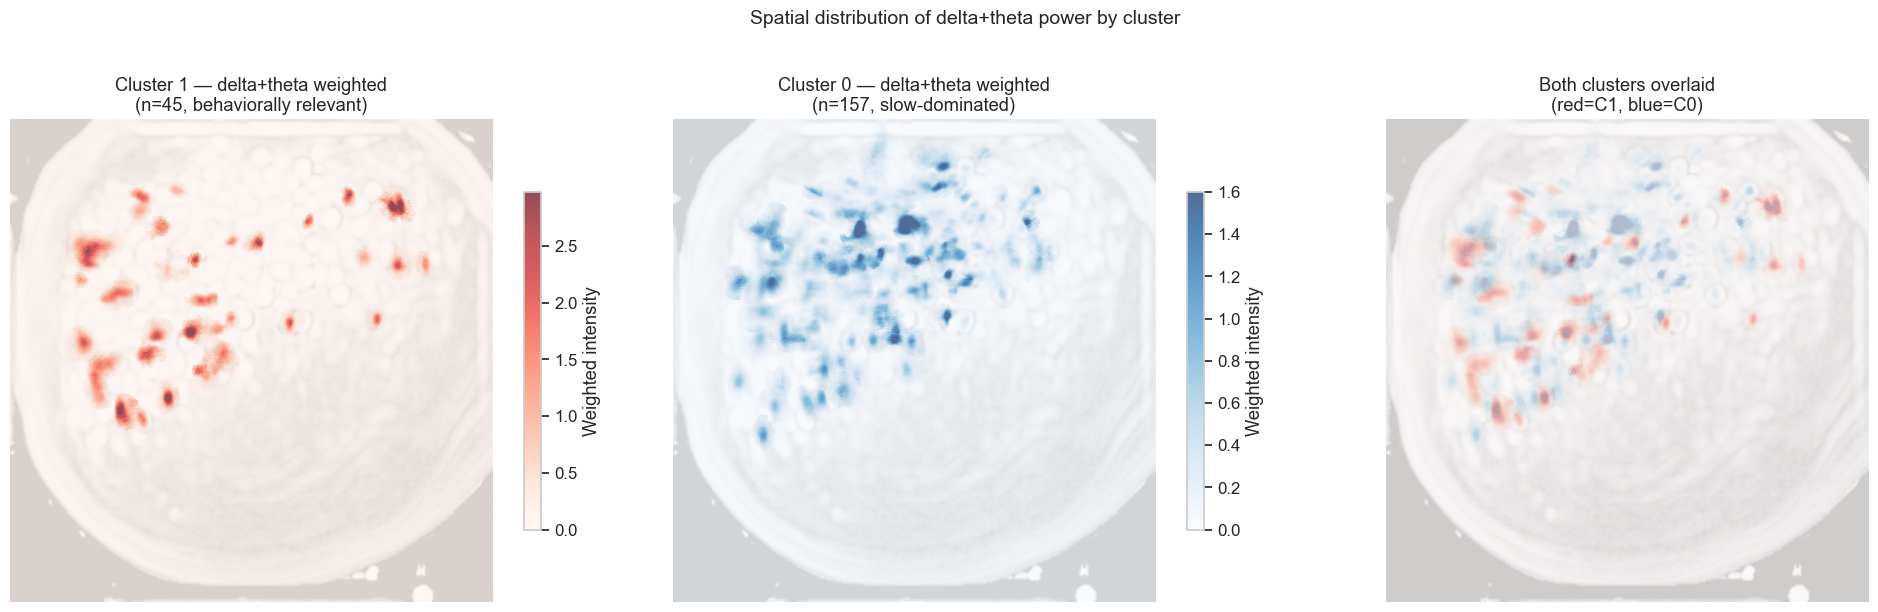

In [10]:
# Compute delta+theta fractional power for each Session 0 neuron
dt_power = np.zeros(A.shape[0])
for _, row in sess0_df.iterrows():
    ni = int(row['neuron_id'])
    dt_power[ni] = row['delta_frac'] + row['theta_frac']

# Build intensity maps weighted by delta+theta power
intensity_c1 = np.zeros_like(Cn, dtype=np.float64)
for ni in c1_idx:
    intensity_c1 += A[ni] * dt_power[ni]

intensity_c0 = np.zeros_like(Cn, dtype=np.float64)
for ni in c0_idx:
    intensity_c0 += A[ni] * dt_power[ni]

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Left: Cluster 1 intensity
axes[0].imshow(Cn, cmap='gray', alpha=0.5)
im0 = axes[0].imshow(intensity_c1, cmap='Reds', alpha=0.7,
                      vmin=0, vmax=np.percentile(intensity_c1[intensity_c1 > 0], 99) if intensity_c1.max() > 0 else 1)
axes[0].set_title(f'Cluster 1 — delta+theta weighted\n(n={len(c1_idx)}, behaviorally relevant)')
axes[0].axis('off')
plt.colorbar(im0, ax=axes[0], shrink=0.7, label='Weighted intensity')

# Middle: Cluster 0 intensity
axes[1].imshow(Cn, cmap='gray', alpha=0.5)
im1 = axes[1].imshow(intensity_c0, cmap='Blues', alpha=0.7,
                      vmin=0, vmax=np.percentile(intensity_c0[intensity_c0 > 0], 99) if intensity_c0.max() > 0 else 1)
axes[1].set_title(f'Cluster 0 — delta+theta weighted\n(n={len(c0_idx)}, slow-dominated)')
axes[1].axis('off')
plt.colorbar(im1, ax=axes[1], shrink=0.7, label='Weighted intensity')

# Right: Both overlaid
axes[2].imshow(Cn, cmap='gray', alpha=0.5)
axes[2].imshow(intensity_c1, cmap='Reds', alpha=0.5,
               vmin=0, vmax=np.percentile(intensity_c1[intensity_c1 > 0], 99) if intensity_c1.max() > 0 else 1)
axes[2].imshow(intensity_c0, cmap='Blues', alpha=0.3,
               vmin=0, vmax=np.percentile(intensity_c0[intensity_c0 > 0], 99) if intensity_c0.max() > 0 else 1)
axes[2].set_title('Both clusters overlaid\n(red=C1, blue=C0)')
axes[2].axis('off')

plt.suptitle('Spatial distribution of delta+theta power by cluster', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

Nearest-neighbor distances (pixels):
  Cluster 0 intra-NN: mean=16.2, median=15.4
  Cluster 1 intra-NN: mean=25.4, median=18.0
  Cluster 1 → Cluster 0 cross-NN: mean=18.2, median=14.2


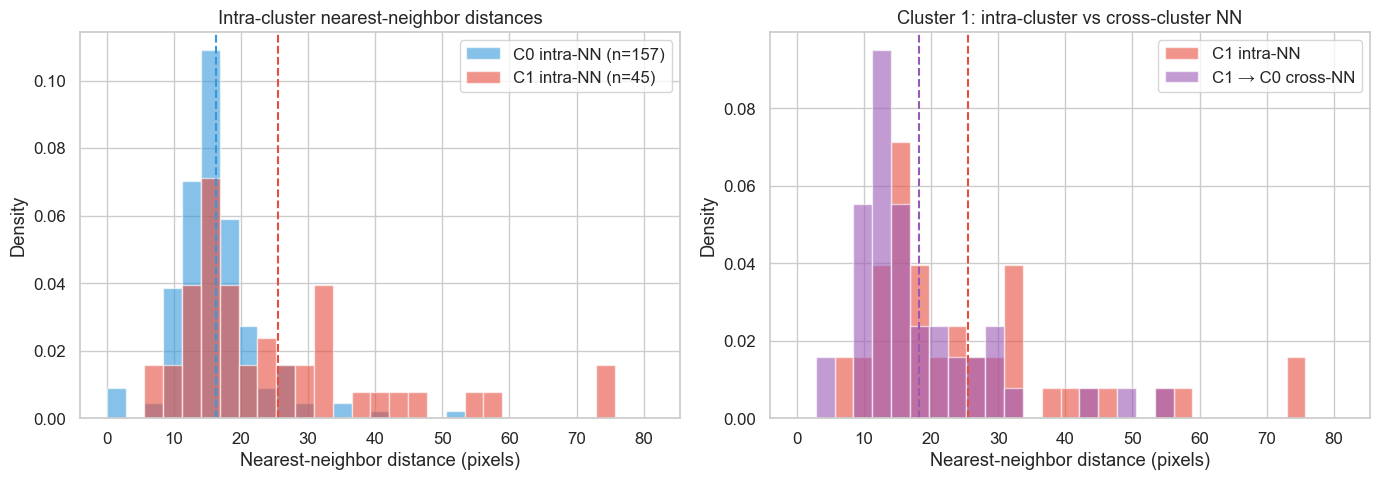

In [11]:
# Nearest-neighbor distance analysis
c0_centroids = centroids_yx[c0_idx]  # (n_c0, 2)
c1_centroids = centroids_yx[c1_idx]  # (n_c1, 2)

# Intra-cluster NN distances
if len(c1_centroids) > 1:
    d_c1 = cdist(c1_centroids, c1_centroids)
    np.fill_diagonal(d_c1, np.inf)
    nn_c1 = d_c1.min(axis=1)  # nearest neighbor within Cluster 1
else:
    nn_c1 = np.array([])

if len(c0_centroids) > 1:
    d_c0 = cdist(c0_centroids, c0_centroids)
    np.fill_diagonal(d_c0, np.inf)
    nn_c0 = d_c0.min(axis=1)  # nearest neighbor within Cluster 0
else:
    nn_c0 = np.array([])

# Cross-cluster: Cluster 1 -> nearest Cluster 0
if len(c1_centroids) > 0 and len(c0_centroids) > 0:
    d_cross = cdist(c1_centroids, c0_centroids)
    nn_c1_to_c0 = d_cross.min(axis=1)
else:
    nn_c1_to_c0 = np.array([])

print('Nearest-neighbor distances (pixels):')
print(f'  Cluster 0 intra-NN: mean={nn_c0.mean():.1f}, median={np.median(nn_c0):.1f}')
print(f'  Cluster 1 intra-NN: mean={nn_c1.mean():.1f}, median={np.median(nn_c1):.1f}')
print(f'  Cluster 1 → Cluster 0 cross-NN: mean={nn_c1_to_c0.mean():.1f}, median={np.median(nn_c1_to_c0):.1f}')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: NN distance histograms
bins = np.linspace(0, max(nn_c0.max(), nn_c1.max()) * 1.1, 30)
axes[0].hist(nn_c0, bins=bins, alpha=0.6, color='#3498db', label=f'C0 intra-NN (n={len(c0_idx)})', density=True)
axes[0].hist(nn_c1, bins=bins, alpha=0.6, color='#e74c3c', label=f'C1 intra-NN (n={len(c1_idx)})', density=True)
axes[0].axvline(nn_c0.mean(), color='#3498db', ls='--', lw=1.5)
axes[0].axvline(nn_c1.mean(), color='#e74c3c', ls='--', lw=1.5)
axes[0].set_xlabel('Nearest-neighbor distance (pixels)')
axes[0].set_ylabel('Density')
axes[0].set_title('Intra-cluster nearest-neighbor distances')
axes[0].legend()

# Right: Cluster 1 intra vs cross-cluster
axes[1].hist(nn_c1, bins=bins, alpha=0.6, color='#e74c3c', label='C1 intra-NN', density=True)
axes[1].hist(nn_c1_to_c0, bins=bins, alpha=0.6, color='#9b59b6', label='C1 → C0 cross-NN', density=True)
axes[1].axvline(nn_c1.mean(), color='#e74c3c', ls='--', lw=1.5)
axes[1].axvline(nn_c1_to_c0.mean(), color='#9b59b6', ls='--', lw=1.5)
axes[1].set_xlabel('Nearest-neighbor distance (pixels)')
axes[1].set_ylabel('Density')
axes[1].set_title('Cluster 1: intra-cluster vs cross-cluster NN')
axes[1].legend()

plt.tight_layout()
plt.show()

### Section 4 Interpretation

The delta+theta weighted intensity maps show where behaviorally-relevant spectral power is concentrated across the field of view. Comparing the Cluster 1 (red) and Cluster 0 (blue) maps reveals whether the high-frequency signal comes from specific spatial hotspots or is distributed.

The nearest-neighbor analysis provides quantitative spatial statistics:
- **Intra-cluster NN distances** measure how tightly packed neurons within each cluster are. Smaller C1 intra-NN distances would suggest co-localization.
- **C1 → C0 cross-cluster NN** measures how close each Cluster 1 neuron is to its nearest Cluster 0 neighbor. If this is similar to the intra-NN distance, the clusters are spatially intermixed; if much larger, they occupy distinct regions.

Together with the centroid scatter (Section 2), these analyses determine whether the spectral cluster identity is a property of individual neurons (cell-type specific) or a property of spatial location (region-specific).